In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from mpl_toolkits.mplot3d import Axes3D

We create a function for the analytical result for detuned driving assuming the rotating wave approximation

In [3]:
def psi_func(t,Omega,Delta,phi):
    Omega_R = np.sqrt(Omega**2+Delta**2)
    
    c_e = -1.j*np.sin(Omega_R*t/2)*(Omega*np.exp(1.j*(phi+t*Delta/2)))/Omega_R
    c_g = (np.cos(Omega_R*t/2)+1.j*np.sin(Omega_R*t/2)*Delta/Omega_R)*np.exp(1.j*t*Delta/2)

    return np.array([c_g,c_e]).T


The following dictionary will allow us to read out any information about the state

In [4]:
def psi_dict(psi_val,psi_time):
    #Create dictionary:
    
    
    psi_name = dict();
    
    #Insert the state into dictionary:
    
    psi_name['psi'] = psi_val
    
    #Allocate time steps
    psi_name['t'] = psi_time
    
    #Absolute values of entries:
    
    psi_name['abs'] = np.absolute(psi_val)
    
    #Populations:
    
    psi_name['pop'] = psi_name['abs']**2
    
    psi_name['pop_g'] =psi_name['pop'][:,0]
    
    psi_name['pop_e'] =psi_name['pop'][:,1]
    
    #Phases on entries:
    psi_name['angles'] = np.angle(psi_val)
    
    psi_name['angle_g']=psi_name['angles'][:,0]
    psi_name['angle_e']=psi_name['angles'][:,1]
    
    #Total phase:
    
    phase = []
    
    for i in range(len(psi_val)):
        phase.append(np.angle(np.vdot(psi_val[0],psi_val[i])))
    
    psi_name['theta'] = np.array(phase)
    
    #Geometric phase construction:
    
    #Azimuthal angle intervals:
    #New idea for implementation, where all angles are defined in complex exponentials to avoid problem with 2pi
    
    #Exponential of current phase difference between the two entries (without scaling)
    psi_name['exp_idphi_t'] = psi_val[:,1]*np.conj(psi_val[:,0])
    
    
    #Exponential time retarded by one step (without scaling)
    psi_name['exp_idphi_past'] = np.append(psi_name['exp_idphi_t'][0],psi_name['exp_idphi_t'])[:-1]
    
    
    #Difference in phase relation exponentiated (Scaling not important, since we take the argument)
    psi_name['exp_idphi'] = psi_name['exp_idphi_t']*np.conj(psi_name['exp_idphi_past'])
    
    #Difference in phase relation
    psi_name['dphi'] = np.angle(psi_name['exp_idphi'])
    
    #Change in geometric phase calculated from minus half the area change on the Bloch sphere 
    psi_name['dtheta_geo'] = -1*psi_name['pop_e']*psi_name['dphi']
    
    #Exponetiated geometric phase
    psi_name['exp_theta_geo'] = np.cumprod(np.exp(1.j*psi_name['dtheta_geo']))
    
    #Geometric phase
    psi_name['theta_geo'] = np.angle(psi_name['exp_theta_geo'])
    
    
    #Dynamic phase construction:
    
    psi_name['dpsi'] = np.append([psi_val[0]],psi_val,axis=0)[:-1]-psi_val
    
    dtheta_dyn = []
    
    for i in range(len(psi_val)):
        dtheta_dyn.append(np.imag(np.vdot(psi_val[i],psi_name['dpsi'][i])))
    
    psi_name['dtheta_dyn'] = np.array(dtheta_dyn)
    
    psi_name['theta_dyn'] = -np.cumsum(psi_name['dtheta_dyn'])
    
    
    #Qutip visualisation:
    
    #Change coords to their f****d convention, which deviates from QM!!!
    
    psi_name['z_coord'] = 2*psi_name['pop_g']-1
    
    #Here the first part is sin(theta) given the half angle nature of the Bloch Sphere
    
    psi_name['dphi_t'] = psi_name['angle_e']-psi_name['angle_g']
    
    psi_name['x_coord'] = 2*psi_name['abs'][:,0]*psi_name['abs'][:,1]*np.cos(psi_name['dphi_t'])
    
    psi_name['y_coord'] = 2*psi_name['abs'][:,0]*psi_name['abs'][:,1]*np.sin(psi_name['dphi_t'])
    
    psi_name['b_coord'] = np.array([psi_name['x_coord'],psi_name['y_coord'],psi_name['z_coord']]).T
    
    
    return psi_name

We will now create a function, which takes our state through one revolution and applies several different transformations to the state:

In [5]:
def psi_trans(Omega=1, Delta=0.5, n_tau = 5,dt = 0.001, phi = 0, omega_gauge = 0.1, E = 1, ratio_triangle = 0.8, n_tri = 200 ):
    
    Omega_R = np.sqrt(Omega**2+Delta**2)

    #Time for one revolution:
    t_f = 2*np.pi/Omega_R

    #Time array:
    t = np.arange(0,t_f,dt)

    #Frequency for time reparametrized array
    omega_tau = n_tau*2*np.pi/t_f
    
    #Time reparametrized array:
    tau = t+np.sin(omega_tau*t)/omega_tau

    #Create state:
    psi_val = psi_func(t,Omega,Delta,phi)

    psi_info = psi_dict(psi_val,t)

    #Create time reparametrized state:
    
    psi_val_tau = psi_func(tau,Omega,Delta,phi)

    psi_info_tau = psi_dict(psi_val_tau,t)

    #Create gauge transformation:

    psi_val_gauge = (psi_val.T*np.exp(1.j*omega_gauge*t)).T

    psi_info_gauge = psi_dict(psi_val_gauge,t)

    #Create rotated state:

    #First, we create the Hamiltonian, we want to change into interaction picture wrt

    H = np.array([[0,0],[0,E]])

    psi_val_rot = []

    for i in range(len(t)):
        psi_val_rot.append(np.array([[1,0],[0,np.exp(1.j*E*i*dt)]]).dot(psi_val[i]))
    
    psi_val_rot = np.array(psi_val_rot)

    psi_info_rot = psi_dict(psi_val_rot,t)


    #We now create a rotation, which also alters the projection of the state, we do not drive:

    t0 = -np.arange(0,t_f,dt)/2
    t1 = np.arange(0,t_f,dt)/2
    
    psi_val_0 = psi_func(t0,Omega,Delta,phi)

    psi_info_0 = psi_dict(psi_val_0,t)

    psi_val_1 = psi_func(t1,Omega,Delta,phi)

    psi_info_1 = psi_dict(psi_val_1,t)


    #Thew next section is dedicated to plotting the 'triangle' phase:
    
    i_tri = int(len(t)*ratio_triangle) #Entry we want to plot to

    t_tri = t[i_tri]


    psi_info_0_tri = psi_dict(psi_val_0[:i_tri],t[:i_tri])

    psi_info_1_tri = psi_dict(psi_val_1[:i_tri],t[:i_tri])

    #Final states:

    psi_i = psi_val_0[0]

    psi_0_f = np.exp(-1.j*np.angle(np.vdot(psi_i,psi_val_0[i_tri])))*psi_val_0[i_tri]

    psi_1_f = np.exp(-1.j*np.angle(np.vdot(psi_i,psi_val_1[i_tri])))*psi_val_1[i_tri]


    psi_10_f = np.exp(1.j*np.angle(np.vdot(psi_val_0[i_tri],psi_val_1[i_tri])))*psi_val_1[i_tri]

    #Geodesics:

    theta = np.pi*np.arange(n_tri)/(2*n_tri)

    geo_0 = []

    for i in theta:
        psi_0 = np.sin(i)*psi_i+np.cos(i)*psi_0_f
        N_0 = np.sqrt(np.abs(np.vdot(psi_0,psi_0)))
        geo_0.append((np.sin(i)*psi_i+np.cos(i)*psi_0_f)/N_0)
        
    geo_0 = np.array(geo_0)
    
    geo_0_info = psi_dict(geo_0,theta)

    

    geo_1 = []

    for i in theta:
        psi_1 = np.sin(i)*psi_i+np.cos(i)*psi_1_f
        N_1 = np.sqrt(np.abs(np.vdot(psi_1,psi_1)))
        geo_1.append((np.sin(i)*psi_i+np.cos(i)*psi_1_f)/N_1)
        
    geo_1 = np.array(geo_1)
    
    geo_1_info = psi_dict(geo_1,theta)

    #Combined geo:
    
    geo_10 = []

    for i in theta:
        psi_10 = np.sin(i)*psi_0_f+np.cos(i)*psi_10_f
        N_1 = np.sqrt(np.abs(np.vdot(psi_10,psi_10)))
        geo_10.append(psi_10/N_1)
        
    geo_10 = np.array(geo_10)
    
    geo_10_info = psi_dict(geo_10,theta)
    

    

    return psi_info, psi_info_tau, psi_info_gauge, psi_info_rot, psi_info_0, psi_info_1, t , tau, geo_0_info, psi_info_0_tri, geo_1_info, psi_info_1_tri, geo_10_info, t_tri
    

In [6]:
psi, psi_tau, psi_gauge, psi_rot , psi_0, psi_1, time,tau, geo_0, psi_0_tri, geo_1, psi_1_tri, geo_10, t_tri = psi_trans(Delta=0.5,n_tau=5,phi=np.pi,E =-0.5,omega_gauge=-0.5)


Triangle phase plot:

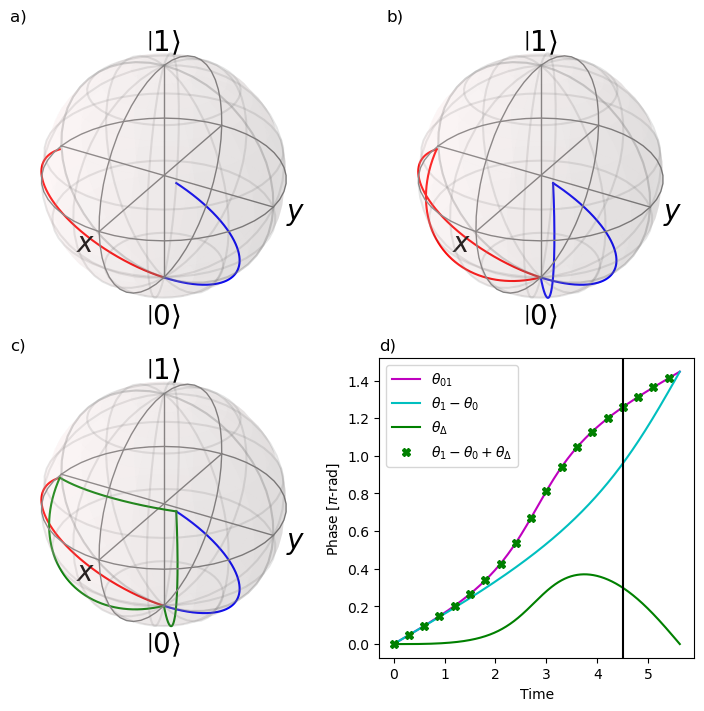

In [7]:
fig = plt.figure(constrained_layout=True,figsize=(7, 7))


#Phase plot
ax4 = fig.add_subplot(2, 2, 4)

ax4.plot(time,(np.angle(np.exp(1.j*(psi['theta']-np.pi)))+np.pi)/np.pi,'m')

ax4.plot(time,(np.angle(np.exp(1.j*(psi_1['theta']-psi_0['theta']-np.pi)))+np.pi)/np.pi,'c')




#Construct excess geometric phase between the reference and the state:
#Construct tangent from populations:
tanR = psi_1['abs'][:,1]/psi_1['abs'][:,0]
tanR_0 = psi_0['abs'][:,1]/psi_0['abs'][:,0]
#Construct cos and sin of polar angle difference between the state and reference:
exp_idel_phi = psi_0['exp_idphi_t']*np.conj(psi_1['exp_idphi_t'])
cos_phi = np.cos(np.angle(exp_idel_phi))
sin_phi = np.sin(np.angle(exp_idel_phi))
#Construct area of the "forgotten" triangle from the above constructions:
E = -2*np.arctan((tanR*tanR_0*sin_phi)/(1+tanR*tanR_0*cos_phi))/(2*np.pi)

#Plot the triangle phase:
ax4.plot(time,E,'g')

plt.title('d)',loc='left')

spacing = 300

#Plot the sum of triangle and phase difference:

ax4.plot(time[::spacing],(np.angle(np.exp(1.j*(psi_1['theta'][::spacing]-psi_0['theta'][::spacing]-np.pi)))+np.pi)/np.pi+E[::spacing],'gX')



ax4.axvline(x=t_tri, color= 'k')

ax4.set_xlabel('Time')

ax4.legend((r'$\theta_{01}$',r'$\theta_1-\theta_0$',r'$\theta_\Delta$',r'$\theta_1-\theta_0+\theta_\Delta$'))

ax4.set_ylabel(r'Phase [$\pi$-rad]')


#Make figure for Bloch sphere (no geo)
ax1 = fig.add_subplot(2, 2, 1, projection='3d')

#Make bloch sphere:

b1 = qutip.Bloch(fig=fig, axes=ax1)

b1.make_sphere()

b1.view = [0,0]




x0 = psi_0_tri['x_coord']

y0 = psi_0_tri['y_coord']

z0 = -psi_0_tri['z_coord']


x0_geo = geo_0['x_coord']

y0_geo = geo_0['y_coord']

z0_geo = -geo_0['z_coord']


x1 = psi_1_tri['x_coord']

y1 = psi_1_tri['y_coord']

z1 = -psi_1_tri['z_coord']


x1_geo = geo_1['x_coord']

y1_geo = geo_1['y_coord']

z1_geo = -geo_1['z_coord']




b1.add_points([x0,y0,z0], meth='l',colors='r')


b1.add_points([x1,y1,z1], meth='l',colors='b')


b1.zlpos = [-1.4,1.2]

b1.sphere_alpha = 0.1



b1.render()

plt.title('a)',loc='left')





#Make figure for Bloch sphere (individual geo)
ax3 = fig.add_subplot(2, 2, 2, projection='3d')


#Make bloch sphere:

b = qutip.Bloch(fig=fig, axes=ax3)

b.make_sphere()

b.view = [0,0]

spacing = 100




x0 = psi_0_tri['x_coord']

y0 = psi_0_tri['y_coord']

z0 = -psi_0_tri['z_coord']


x0_geo = geo_0['x_coord']

y0_geo = geo_0['y_coord']

z0_geo = -geo_0['z_coord']


x1 = psi_1_tri['x_coord']

y1 = psi_1_tri['y_coord']

z1 = -psi_1_tri['z_coord']


x1_geo = geo_1['x_coord']

y1_geo = geo_1['y_coord']

z1_geo = -geo_1['z_coord']




b.add_points([x0,y0,z0], meth='l',colors='r')

b.add_points([x0_geo,y0_geo,z0_geo], meth='l',colors='r')

b.add_points([x1,y1,z1], meth='l',colors='b')

b.add_points([x1_geo,y1_geo,z1_geo], meth='l',colors='b')

b.point_size= [10,10,55,55]

b.zlpos = [-1.4,1.2]

b.sphere_alpha = 0.1



b.render()


plt.title('b)',loc='left')




#Make figure for Bloch sphere (Trig geo)
ax2 = fig.add_subplot(2, 2, 3, projection='3d')

#Make bloch sphere:

b2 = qutip.Bloch(fig=fig, axes=ax2)

b2.make_sphere()

b2.view = [0,0]




x0 = psi_0_tri['x_coord']

y0 = psi_0_tri['y_coord']

z0 = -psi_0_tri['z_coord']


x0_geo = geo_0['x_coord']

y0_geo = geo_0['y_coord']

z0_geo = -geo_0['z_coord']


x1 = psi_1_tri['x_coord']

y1 = psi_1_tri['y_coord']

z1 = -psi_1_tri['z_coord']


x1_geo = geo_1['x_coord']

y1_geo = geo_1['y_coord']

z1_geo = -geo_1['z_coord']


x10_geo = geo_10['x_coord']

y10_geo = geo_10['y_coord']

z10_geo = -geo_10['z_coord']




b2.add_points([x0,y0,z0], meth='l',colors='r')

b2.add_points([x0_geo,y0_geo,z0_geo], meth='l',colors='g')


b2.add_points([x1,y1,z1], meth='l',colors='b')

b2.add_points([x1_geo,y1_geo,z1_geo], meth='l',colors='g')

b2.add_points([x10_geo,y10_geo,z10_geo], meth='l',colors='g')







b2.zlpos = [-1.4,1.2]

b2.sphere_alpha = 0.1



b2.render()

plt.title('c)',loc='left')






plt.savefig('TrianglePhase')

plt.show()



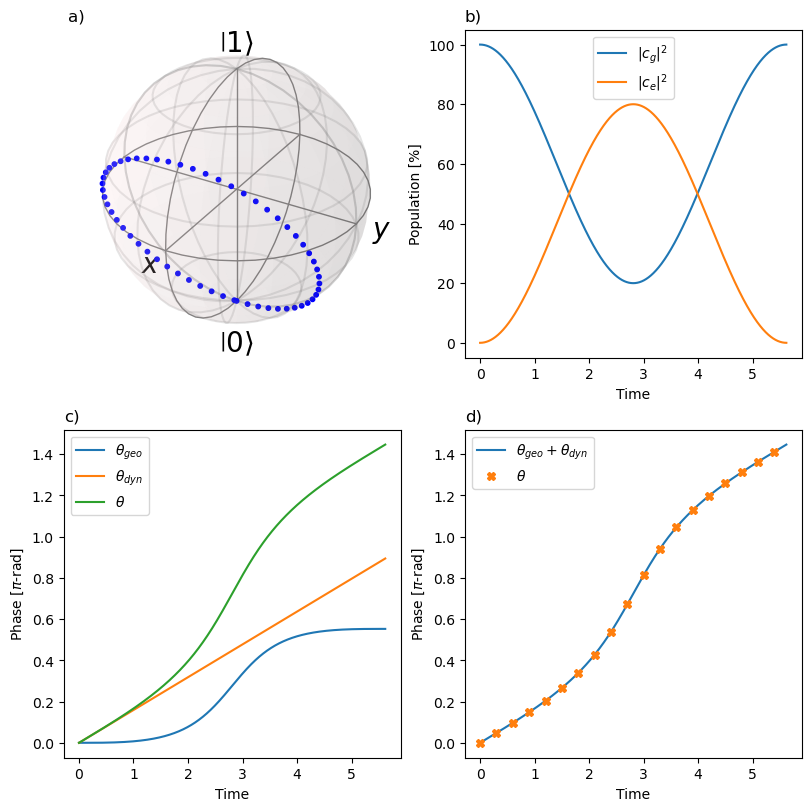

In [8]:
fig = plt.figure(constrained_layout=True,figsize=(8, 8))



ax1 = fig.add_subplot(2, 2, 2)
ax1.plot(time,100*psi['pop'])

#ax1.set_xlabel('time')

ax1.set_ylabel('Population [%]')

ax1.legend((r'$|c_g|^2$',r'$|c_e|^2$'),loc='upper center')

ax1.set_xlabel('Time')

plt.title('b)',loc='left')

ax2 = fig.add_subplot(2, 2, 3)

ax2.plot(time,psi['theta_geo']/np.pi)

ax2.plot(time,psi['theta_dyn']/np.pi)

ax2.plot(time,(np.angle(np.exp(1.j*(psi['theta']-np.pi)))+np.pi)/np.pi)

ax2.set_xlabel('Time')

ax2.set_ylabel(r'Phase [$\pi$-rad]')

ax2.legend((r'$\theta_{geo}$',r'$\theta_{dyn}$',r'$\theta$'))

plt.title('c)',loc='left')

ax4 = fig.add_subplot(2, 2, 4)

spacing0 = 300

ax4.plot(time,(np.angle(np.exp(1.j*(psi['theta_geo']+psi['theta_dyn']-np.pi)))+np.pi)/np.pi)

ax4.plot(time[::spacing0],(np.angle(np.exp(1.j*(psi['theta'][::spacing0]-np.pi)))+np.pi)/np.pi,'X')

ax4.set_xlabel('Time')

ax4.legend((r'$\theta_{geo}+\theta_{dyn}$',r'$\theta$'))

ax4.set_ylabel(r'Phase [$\pi$-rad]')

plt.title('d)',loc='left')

#Make figure for Bloch sphere
ax3 = fig.add_subplot(2, 2, 1, projection='3d')



#Make bloch sphere:

b = qutip.Bloch(fig=fig, axes=ax3)

b.make_sphere()

spacing = 100

x = psi['x_coord'][::spacing]

y = psi['y_coord'][::spacing]

z = -psi['z_coord'][::spacing]

x_0 = [0]

y_0 = [0]

z_0 = [-1]



b.add_points([x,y,z])

#b.add_points([x_0,y_0,z_0])

b.point_size= [10,55,55,55]

b.zlpos = [-1.4,1.2]

b.sphere_alpha = 0.1

b.render()
#ax3.set_box_aspect([1, 1, 1]) # required for mpl > 3.1

plt.title('a)',loc='left')

plt.savefig('NormalDriving')

plt.show()



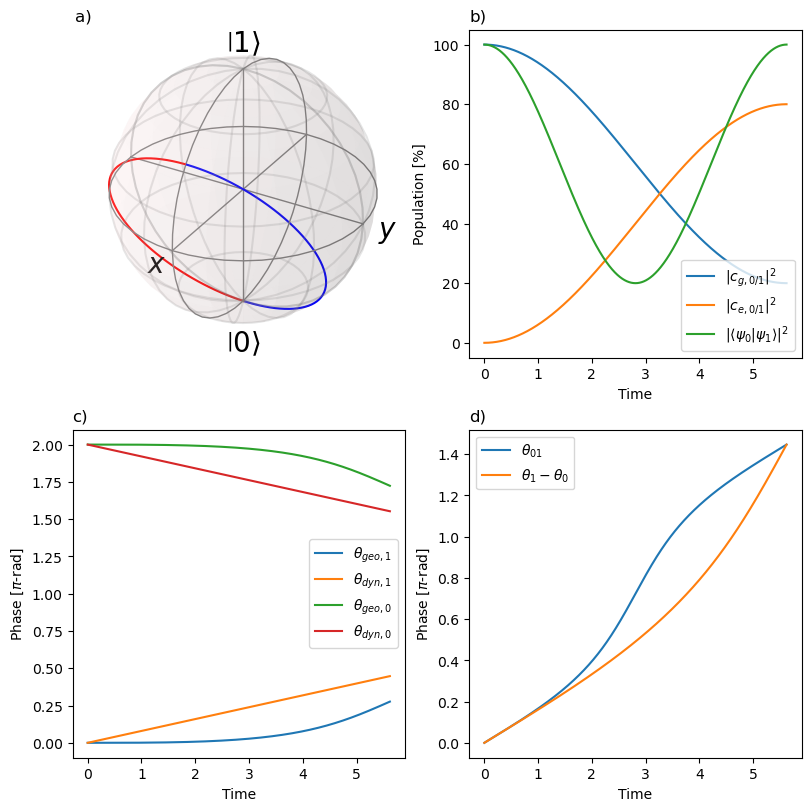

In [9]:
fig = plt.figure(constrained_layout=True,figsize=(8, 8))

spacing0 = 300

ax1 = fig.add_subplot(2, 2, 2)
ax1.plot(time,100*psi_1['pop'])

#ax1.plot(time[::spacing0],100*psi_0['pop'][::spacing0],'X')

pop_ref = []

for i in range(len(time)):
    overlap = np.abs(np.vdot(psi_1['psi'][i],psi_0['psi'][i]))
    pop_ref.append(overlap**2)

pop_ref = np.array(pop_ref)

ax1.plot(time,100*pop_ref)


#ax1.set_xlabel('time')

ax1.set_ylabel('Population [%]')

ax1.legend((r'$|c_{g,0/1}|^2$',r'$|c_{e,0/1}|^2$',r'$|\langle\psi_0|\psi_1\rangle|^2$'),loc='lower right')



ax1.set_xlabel('Time')

plt.title('b)',loc='left')

ax2 = fig.add_subplot(2, 2, 3)

#ax2.plot(time,psi['theta_geo']/np.pi)

#ax2.plot(time,psi['theta_dyn']/np.pi)

ax2.plot(time,(np.angle(np.exp(1.j*(psi_1['theta_geo']-np.pi)))+np.pi)/np.pi)

ax2.plot(time,(np.angle(np.exp(1.j*(psi_1['theta_dyn']-np.pi)))+np.pi)/np.pi)

ax2.plot(time[2:],(np.angle(np.exp(1.j*(psi_0['theta_geo'][2:]-np.pi)))+np.pi)/np.pi)

ax2.plot(time[1:],(np.angle(np.exp(1.j*(psi_0['theta_dyn'][1:]-np.pi)))+np.pi)/np.pi)




ax2.set_xlabel('Time')

ax2.set_ylabel(r'Phase [$\pi$-rad]')

ax2.legend((r'$\theta_{geo,1}$',r'$\theta_{dyn,1}$',r'$\theta_{geo,0}$',r'$\theta_{dyn,0}$'))

plt.title('c)',loc='left')

ax4 = fig.add_subplot(2, 2, 4)



ax4.plot(time,(np.angle(np.exp(1.j*(psi['theta']-np.pi)))+np.pi)/np.pi)

ax4.plot(time,(np.angle(np.exp(1.j*(psi_1['theta']-psi_0['theta']-np.pi)))+np.pi)/np.pi)

ax4.set_xlabel('Time')

ax4.legend((r'$\theta_{01}$',r'$\theta_1-\theta_0$'))

ax4.set_ylabel(r'Phase [$\pi$-rad]')

plt.title('d)',loc='left')

#Make figure for Bloch sphere
ax3 = fig.add_subplot(2, 2, 1, projection='3d')



#Make bloch sphere:

b = qutip.Bloch(fig=fig, axes=ax3)

b.make_sphere()

spacing = 100

x1 = psi_1['x_coord'][::spacing]

y1 = psi_1['y_coord'][::spacing]

z1 = -psi_1['z_coord'][::spacing]


x0 = psi_0['x_coord'][::spacing]

y0 = psi_0['y_coord'][::spacing]

z0 = -psi_0['z_coord'][::spacing]


b.add_points([x1,y1,z1],meth='l')

b.add_points([x0,y0,z0],meth='l')

b.point_size= [10,10,55,55]

b.zlpos = [-1.4,1.2]

b.sphere_alpha = 0.1

b.render()
#ax3.set_box_aspect([1, 1, 1]) # required for mpl > 3.1

plt.title('a)',loc='left')

plt.savefig('RotatedDriving')

plt.show()


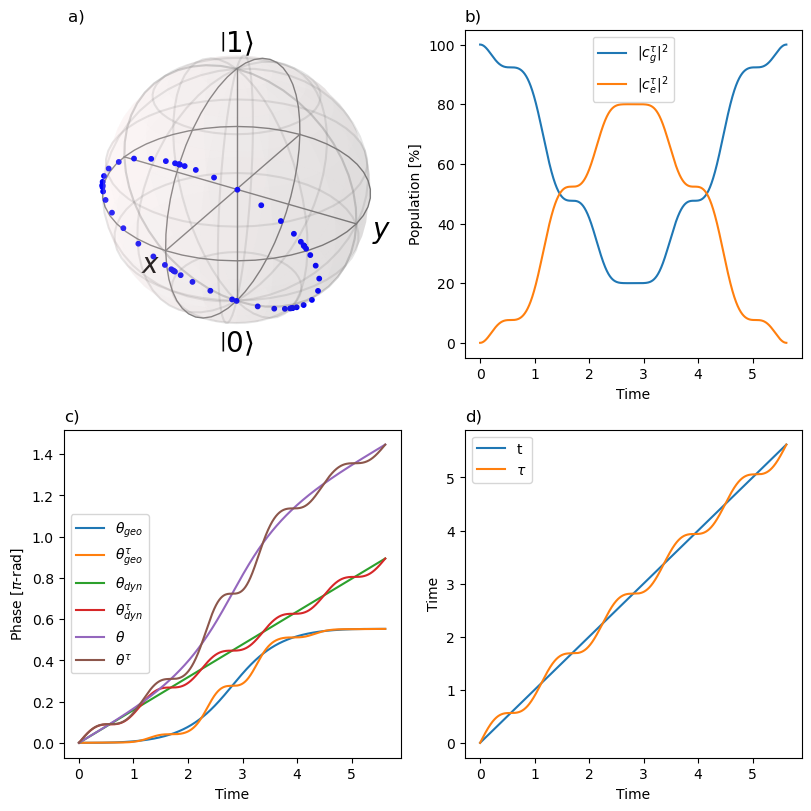

In [10]:
fig = plt.figure(constrained_layout=True,figsize=(8, 8))



ax1 = fig.add_subplot(2, 2, 2)
ax1.plot(time,100*psi_tau['pop'])

#ax1.set_xlabel('time')

ax1.set_ylabel('Population [%]')

ax1.legend((r'$|c_g^\tau|^2$',r'$|c_e^\tau|^2$'),loc='upper center')

ax1.set_xlabel('Time')

plt.title('b)',loc='left')

ax2 = fig.add_subplot(2, 2, 3)

ax2.plot(time,psi['theta_geo']/np.pi)

ax2.plot(time,psi_tau['theta_geo']/np.pi)

ax2.plot(time,psi['theta_dyn']/np.pi)

ax2.plot(time,psi_tau['theta_dyn']/np.pi)

ax2.plot(time,(np.angle(np.exp(1.j*(psi['theta']-np.pi)))+np.pi)/np.pi)

ax2.plot(time,(np.angle(np.exp(1.j*(psi_tau['theta']-np.pi)))+np.pi)/np.pi)



ax2.set_xlabel('Time')

ax2.set_ylabel(r'Phase [$\pi$-rad]')

ax2.legend((r'$\theta_{geo}$',r'$\theta_{geo}^\tau$',r'$\theta_{dyn}$',r'$\theta_{dyn}^\tau$',r'$\theta$',r'$\theta^\tau$'),loc='center left')

plt.title('c)',loc='left')

ax4 = fig.add_subplot(2, 2, 4)


ax4.plot(time,time)

ax4.plot(time,tau)



ax4.set_xlabel('Time')

ax4.set_ylabel('Time')

ax4.legend(('t',r'$\tau$'))

plt.title('d)',loc='left')

#Make figure for Bloch sphere
ax3 = fig.add_subplot(2, 2, 1, projection='3d')



#Make bloch sphere:

b = qutip.Bloch(fig=fig, axes=ax3)

b.make_sphere()

spacing = 100

x = psi_tau['x_coord'][::spacing]

y = psi_tau['y_coord'][::spacing]

z = -psi_tau['z_coord'][::spacing]


b.add_points([x,y,z])

b.point_size= [10,55,55,55]

b.zlpos = [-1.4,1.2]

b.sphere_alpha = 0.1

b.render()
#ax3.set_box_aspect([1, 1, 1]) # required for mpl > 3.1

plt.title('a)',loc='left')

plt.savefig('TimeReP')

plt.show()

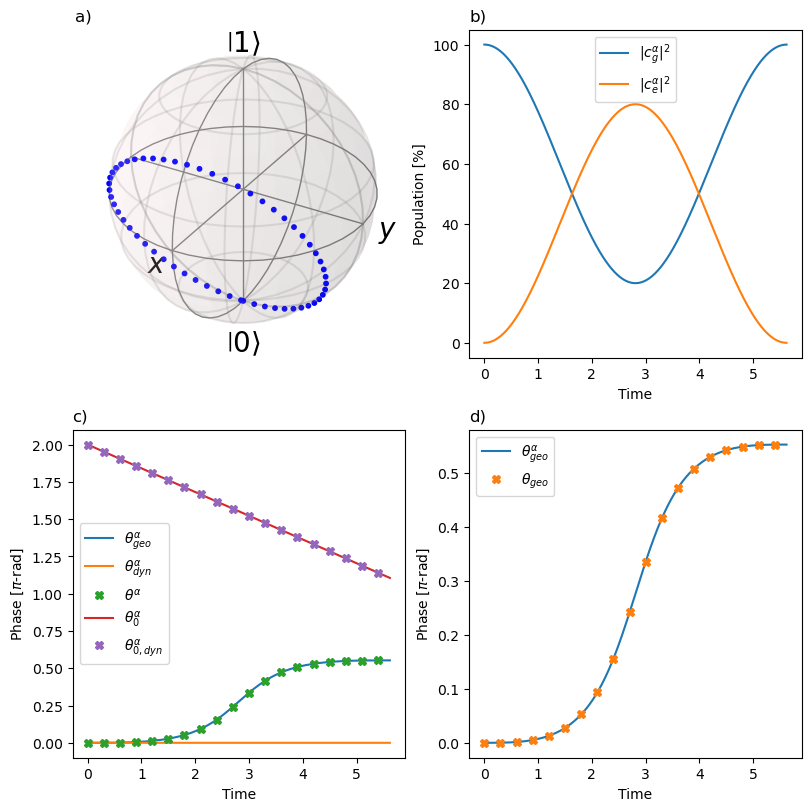

In [13]:
fig = plt.figure(constrained_layout=True,figsize=(8, 8))



ax1 = fig.add_subplot(2, 2, 2)
ax1.plot(time,100*psi_gauge['pop'])

#ax1.set_xlabel('time')

ax1.set_ylabel('Population [%]')

ax1.legend((r'$|c_g^\alpha|^2$',r'$|c_e^\alpha|^2$'),loc='upper center')

ax1.set_xlabel('Time')

plt.title('b)',loc='left')

ax2 = fig.add_subplot(2, 2, 3)

ax2.plot(time,psi_gauge['theta_geo']/np.pi)

ax2.plot(time,psi_gauge['theta_dyn']/np.pi)



spacing0 = 300

ax2.plot(time[::spacing0],(np.angle(np.exp(1.j*(psi_gauge['theta'][::spacing0]-np.pi)))+np.pi)/np.pi,'X')

ax2.plot(time,2-psi['theta_dyn']/np.pi)

ax2.plot(time[::spacing0],2-psi['theta_dyn'][::spacing0]/np.pi,'X')

ax2.set_xlabel('Time')

ax2.set_ylabel(r'Phase [$\pi$-rad]')

ax2.legend((r'$\theta_{geo}^\alpha$',r'$\theta_{dyn}^\alpha$',r'$\theta^\alpha$',r'$\theta_0^\alpha$',r'$\theta_{0,dyn}^\alpha$'))



plt.title('c)',loc='left')

ax4 = fig.add_subplot(2, 2, 4)


ax4.plot(time,psi_gauge['theta_geo']/np.pi)

ax4.plot(time[::spacing0],psi['theta_geo'][::spacing0]/np.pi,'X')

ax4.legend((r'$\theta_{geo}^\alpha$',r'$\theta_{geo}$'))

ax4.set_xlabel('Time')

ax4.set_ylabel(r'Phase [$\pi$-rad]')

plt.title('d)',loc='left')

#Make figure for Bloch sphere
ax3 = fig.add_subplot(2, 2, 1, projection='3d')



#Make bloch sphere:

b = qutip.Bloch(fig=fig, axes=ax3)

b.make_sphere()

spacing = 100

x = psi_gauge['x_coord'][::spacing]

y = psi_gauge['y_coord'][::spacing]

z = -psi_gauge['z_coord'][::spacing]


b.add_points([x,y,z])

b.point_size= [10,55,55,55]

b.zlpos = [-1.4,1.2]

b.sphere_alpha = 0.1

b.render()
#ax3.set_box_aspect([1, 1, 1]) # required for mpl > 3.1

plt.title('a)',loc='left')

#plt.savefig('GaugeTrans')

plt.show()

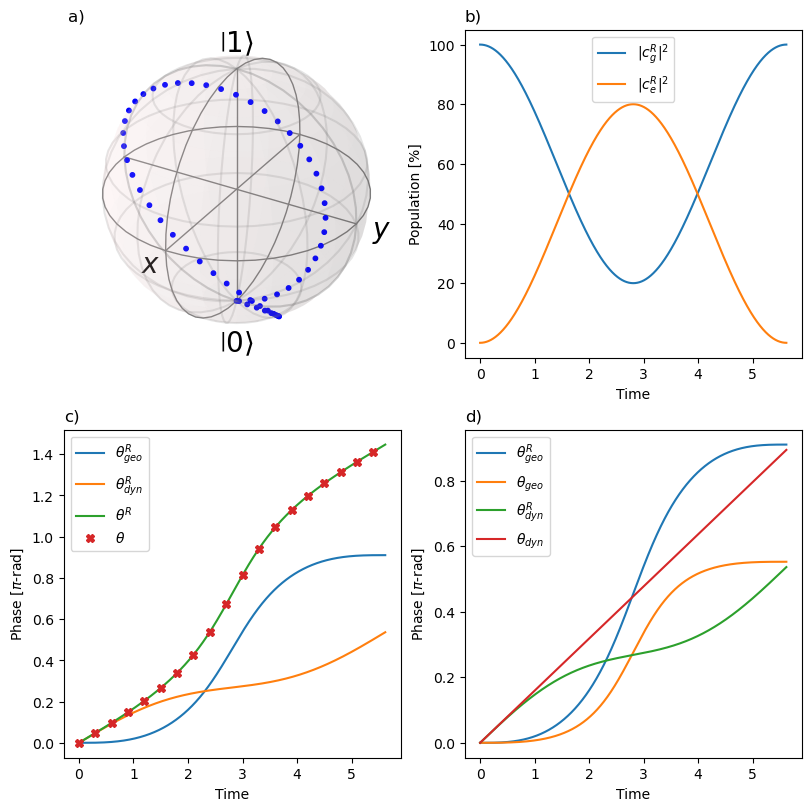

In [24]:
fig = plt.figure(constrained_layout=True,figsize=(8, 8))



ax1 = fig.add_subplot(2, 2, 2)
ax1.plot(time,100*psi_rot['pop'])

#ax1.set_xlabel('time')

ax1.set_ylabel('Population [%]')

ax1.legend((r'$|c_g^R|^2$',r'$|c_e^R|^2$'),loc='upper center')

ax1.set_xlabel('Time')

plt.title('b)',loc='left')

ax2 = fig.add_subplot(2, 2, 3)

ax2.plot(time,psi_rot['theta_geo']/np.pi)

ax2.plot(time,psi_rot['theta_dyn']/np.pi)

spacing0 = 300

ax2.plot(time,(np.angle(np.exp(1.j*(psi_rot['theta']-np.pi)))+np.pi)/np.pi)

ax2.plot(time[::spacing0],(np.angle(np.exp(1.j*(psi['theta'][::spacing0]-np.pi)))+np.pi)/np.pi,'X')

ax2.set_xlabel('Time')

ax2.set_ylabel(r'Phase [$\pi$-rad]')

ax2.legend((r'$\theta_{geo}^R$',r'$\theta_{dyn}^R$',r'$\theta^R$',r'$\theta$'))

plt.title('c)',loc='left')

ax4 = fig.add_subplot(2, 2, 4)


ax4.plot(time,psi_rot['theta_geo']/np.pi)

ax4.plot(time,psi['theta_geo']/np.pi)

ax4.plot(time,psi_rot['theta_dyn']/np.pi)

ax4.plot(time,psi['theta_dyn']/np.pi)

ax4.legend((r'$\theta_{geo}^R$',r'$\theta_{geo}$',r'$\theta_{dyn}^R$',r'$\theta_{dyn}$'))

ax4.set_xlabel('Time')

ax4.set_ylabel(r'Phase [$\pi$-rad]')

plt.title('d)',loc='left')

#Make figure for Bloch sphere
ax3 = fig.add_subplot(2, 2, 1, projection='3d')



#Make bloch sphere:

b = qutip.Bloch(fig=fig, axes=ax3)

b.make_sphere()

spacing = 100

x = psi_rot['x_coord'][::spacing]

y = psi_rot['y_coord'][::spacing]

z = -psi_rot['z_coord'][::spacing]


b.add_points([x,y,z])

b.point_size= [10,55,55,55]

b.zlpos = [-1.4,1.2]

b.sphere_alpha = 0.1

b.render()
#ax3.set_box_aspect([1, 1, 1]) # required for mpl > 3.1

plt.title('a)',loc='left')

plt.savefig('InteractionPic')

plt.show()